In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

#from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

In [3]:
filename = 'D:\\Sandbox\\Github\\Data\\AirPassengers.csv'

In [4]:
df = pd.read_csv(filename)
df.Month = pd.to_datetime(df.Month)
df = df.set_index("Month")
df.head()

,AirPassengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   AirPassengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [6]:
train = df[:-12]    # 12 months for test and rest for training data split 
test  = df[-12:]

In [7]:
print(len(train))
print(len(test))

132
12


In [8]:
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

In [9]:
n_input = 12    # no of months as time step interval for the time series
n_features = 1  # only one value series
batch_size = 6

In [10]:
len(train)

132

In [11]:
generator = TimeseriesGenerator(train, 
                                train, 
                                length=n_input, 
                                batch_size=batch_size)

In [12]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dropout(0.15))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [13]:
model.fit(generator,epochs=90, verbose=0)

In [14]:
pred_list = []

batch = train[-n_input:].reshape((1, n_input, n_features))   # stepping stone value

for i in range(n_input):   
    pred_list.append(model.predict(batch)[0])                # predict and save in list
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1) # next value for prediction

In [15]:
#df[-12:].index   # past 12 months

In [16]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=df[-n_input:].index, 
                          columns=['Prediction'])

In [17]:
df_predict

,Prediction
Month,
1960-01-01,372.688320
1960-02-01,372.377577
1960-03-01,401.314847
1960-04-01,403.953200
1960-05-01,447.965890
1960-06-01,526.850679
1960-07-01,604.535375
1960-08-01,596.066903
1960-09-01,501.551003


In [18]:
df_test = pd.concat([df,df_predict], axis=1)

In [19]:
df_test

,AirPassengers,Prediction
Month,,
1949-01-01,112,NaN
1949-02-01,118,NaN
1949-03-01,132,NaN
1949-04-01,129,NaN
1949-05-01,121,NaN
...,...,...
1960-08-01,606,596.066903
1960-09-01,508,501.551003
1960-10-01,461,435.906497


In [20]:
#pred_actual_rmse = rmse(df_test.iloc[-n_input:, [0]], df_test.iloc[-n_input:, [1]])
#print("rmse: ", pred_actual_rmse)

from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(df_test.iloc[-n_input:, [0]], df_test.iloc[-n_input:, [1]])) #error acceptable?

26.2484785556861

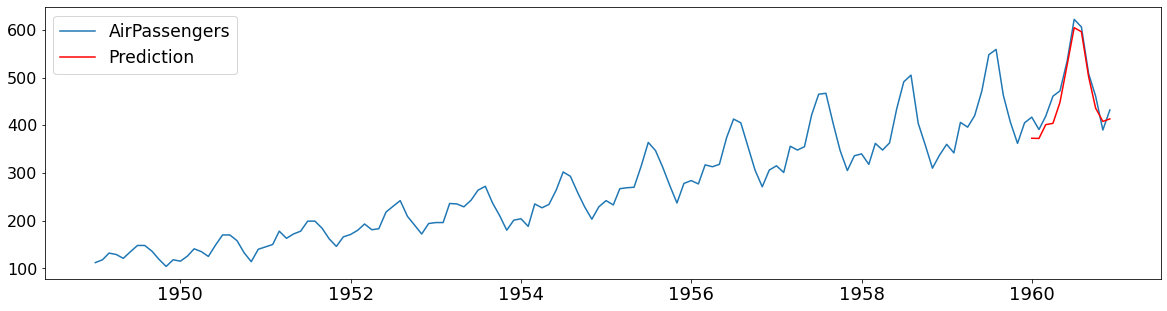

In [21]:
plt.figure(figsize=(20, 5))
plt.plot(df_test.index, df_test['AirPassengers'])
plt.plot(df_test.index, df_test['Prediction'], color='r')
plt.legend(["AirPassengers", "Prediction"], loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

In [22]:
# This time train is using the full df for the future forecasting
train = df
len(train)

144

In [23]:
scaler.fit(train)
train = scaler.transform(train)

In [24]:
n_input = 12
n_features = 1
batch_size=6

In [25]:
generator = TimeseriesGenerator(train, 
                                train, 
                                length=n_input, 
                                batch_size=batch_size)

In [26]:
model.fit(generator,epochs=90, verbose=0)

In [27]:
pred_list = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):   
    pred_list.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

In [28]:
from pandas.tseries.offsets import DateOffset
add_dates = [df.index[-1] + DateOffset(months=x) for x in range(0,13) ]
future_dates = pd.DataFrame(index=add_dates[1:],
                            columns=df.columns)

In [29]:
future_dates

,AirPassengers
1961-01-01,NaN
1961-02-01,NaN
1961-03-01,NaN
1961-04-01,NaN
1961-05-01,NaN
1961-06-01,NaN
1961-07-01,NaN
1961-08-01,NaN
1961-09-01,NaN
1961-10-01,NaN


In [30]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=future_dates[-n_input:].index, 
                          columns=['Prediction'])

In [31]:
df_projected = pd.concat([df,df_predict], axis=1)

In [32]:
df_projected

,AirPassengers,Prediction
1949-01-01,112.0,NaN
1949-02-01,118.0,NaN
1949-03-01,132.0,NaN
1949-04-01,129.0,NaN
1949-05-01,121.0,NaN
...,...,...
1961-08-01,NaN,651.608767
1961-09-01,NaN,563.485989
1961-10-01,NaN,498.138584
1961-11-01,NaN,448.553590


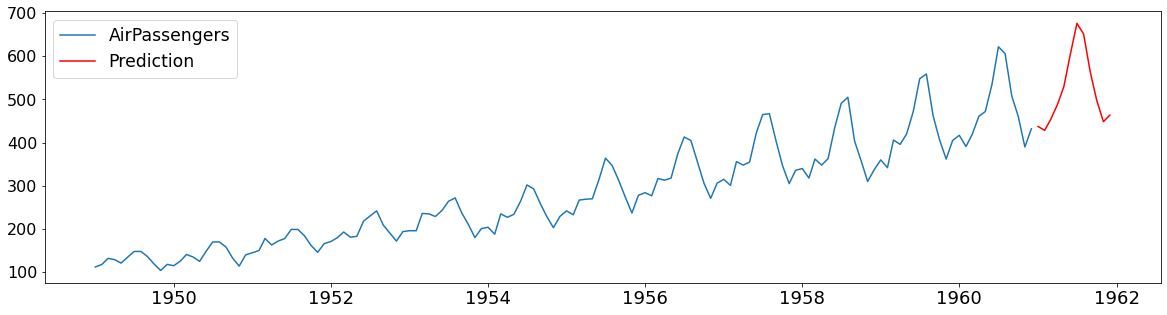

In [33]:
plt.figure(figsize=(20, 5))
plt.plot(df_projected.index, df_projected['AirPassengers'])
plt.plot(df_projected.index, df_projected['Prediction'], color='r')
plt.legend(["AirPassengers", "Prediction"], loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()